
<center><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/5/5c/Olympic_rings_without_rims.svg/1024px-Olympic_rings_without_rims.svg.png" alt="Olympic Rings" style="width: 300px;"/></center>

# Running the Track:
# Olympic Athletes from Athens 1896 to Beijing 2022

## The Data
The data being analyzed comes from the [Event to Athlete level Olympic Games Results from Athens 1896 to Beijing 2022](https://www.kaggle.com/datasets/josephcheng123456/olympic-historical-dataset-from-olympediaorg?resource=download&select=Olympic_Athlete_Event_Results.csv) provided by Joseph Cheng on Kaggle, and was originally sourced from [Olympedia.org](https://www.olympedia.org).

## Project Objectives
For this project, I will be focusing on the athletes and performances in the track and running events at the summer olympics. The primary objective is to address the question: `How have the running events in the Olympic Games changed over the span of 120+ years of competition?` This will be broken down into smaller questions focused on the performances and builds of each athlete, the distribution of athelets in the different running events, and the representation of countries and athelets in the Games.

### The Olympic Games
+ How has the participation in the events changed over time?
+ How has the representation in the events changed over time?

### The Athletes
+ How have athletes' body compositions changed over time?
+ How are athlete body compositions distributed across the different events?
+ What does a champion look like in each event? Has this changed in the modern era?
    + Height
    + Weight
    + Age 
+ What is the correlation between height and weight?
    + For sprinting events?
    + For mid-distance events?
    + For long-distance events? 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

## Data Cleaning
We will start by loading the data into a dataframe, removing any duplicate colums left over from joining the tables in the database, removing any columns that will not be helpful for anaylizing athletes' builds or performances. Also, since the objective of this project is to analyze olympic running events, we will be removing any rows from the winter olympics.

In [2]:
all_data = pd.read_csv("olympics_1896to2022.csv")

In [3]:
# There are 6 duplicated columns from joining the tables together in SQL, indicated by the '.1' in the column name.
# Drop the duplicated columns.
all_data.drop(labels=['athlete_id.1','country_noc.1','result_id.1','edition.1', 'edition_id.1', 'sport.1'], axis=1, inplace=True)

In [4]:
#break edition into year and season, then drop edition.
all_data['year'] = all_data['edition'].apply(lambda x: x.split(" ")[0])
all_data['season'] = all_data['edition'].apply(lambda x: x.split(" ")[1])
all_data.drop(labels=['edition'], axis=1, inplace=True)

In [5]:
#break result_participants into num_competitors and num_countries
def get_competitors(result_participant):
    if pd.isnull(result_participant):
        return None
    else:
        return str(result_participant).split(" ")[0]

def get_countries(result_participant):
    if pd.isnull(result_participant):
        return None
    else:
        return str(result_participant).split(" ")[2]
        
all_data['num_competitors'] = all_data['result_participants'].apply(get_competitors)
all_data['num_countries'] = all_data['result_participants'].apply(get_countries)
all_data.drop(labels=['result_participants'], axis=1, inplace=True)

In [6]:
# Columns event and event_title contain the same information, athlete and name contain the same information.
all_data.drop(labels=['event_title', 'name'], axis=1, inplace=True)

# Drop columns that will not be utilized for analysis on athletes or performances.
all_data.drop(labels=['special_notes', #fun facts 
                      'sport_url', #link to event on olympedia.org
                      'description', #biography of some athletes
                      'result_description', #paragraph of extra context surrounding the result
                      'result_location', #where the event was hosted
                      'result_detail'], #90% na, the other 10% is a mixture of names, country codes, course measurements
             axis=1, 
             inplace=True)

In [7]:
#Track and Field is only a part of the summer games, so filter the DF by season.
summer_games = all_data[all_data.season == 'Summer']
#summer_games.head()

In [8]:
#Track and Field is cl/assified as 'Athletics', so filter the DF by sport.
summer_athletics = pd.DataFrame(summer_games[summer_games.sport == 'Athletics'])
summer_athletics.drop(labels=['sport'], axis=1, inplace=True)

In [9]:
#The column 'event' contains information about both the event AND the gender, which is repeated in the column 'sex'
#Trim the gender out of the event column.
summer_athletics.event = summer_athletics.event.apply(lambda x: ','.join(x.split(',')[:-1]))
#abbreviate kilo --> k
#abbreviate metres --> m
summer_athletics.event = summer_athletics.event.apply(lambda x: x.replace("kilo", 'k').replace("metres",'m'))
summer_athletics

,edition_id,country_noc,event,result_id,athlete,athlete_id,pos,medal,isTeamSport,sex,...,weight,country,result_format,start_date,end_date,time,year,season,num_competitors,num_countries
0,5,ANZ,100 m,56265,Ernest Hutcheon,64710,DNS,na,False,Male,...,na,Australasia,na,1908-07-20,1908-07-22,na,1908,Summer,60,16
1,5,ANZ,400 m,56313,Henry Murray,64756,DNS,na,False,Male,...,na,Australasia,na,1908-07-21,1908-07-25,na,1908,Summer,37,11
2,5,ANZ,800 m,56338,Harvey Sutton,64808,3 h8 r1/2,na,False,Male,...,na,Australasia,na,1908-07-20,1908-07-21,na,1908,Summer,38,11
3,5,ANZ,800 m,56338,Guy Haskins,922519,DNS,na,False,Male,...,na,Australasia,na,1908-07-20,1908-07-21,na,1908,Summer,38,11
4,5,ANZ,800 m,56338,Joseph Lynch,64735,DNS,na,False,Male,...,na,Australasia,na,1908-07-20,1908-07-21,na,1908,Summer,38,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
313889,61,USA,4 × 400 m Relay,19000947,Vernon Norwood,147355,3,Bronze,True,Male,...,73,United States,na,2021-07-30,2021-07-31,na,2020,Summer,76,15
313890,61,USA,4 × 400 m Relay,19000947,Elija Godwin,147325,3,Bronze,True,Male,...,na,United States,na,2021-07-30,2021-07-31,na,2020,Summer,76,15
313891,61,USA,4 × 400 m Relay,19000947,Lynna Irby,147119,3,Bronze,True,Female,...,na,United States,na,2021-07-30,2021-07-31,na,2020,Summer,76,15
313892,61,USA,4 × 400 m Relay,19000947,Taylor Manson,147130,3,Bronze,True,Female,...,na,United States,na,2021-07-30,2021-07-31,na,2020,Summer,76,15


### Changing Events
Over the 120+ years of competition, the running events at the olypmics have evolved and changed. Some events were run at only one or two olympic games before being discontinued. Other events saw their distances change over time as standards for track competition were established. To properly analyze changes in athletes and performances over time, these events will need to be filtered and grouped.

The following sections of code are intended to work the data frame into its final form before the data can be inspected for missing or incorrect data entries.

In [10]:
summer_athletics.event.unique()

array(['100 m', '400 m', '800 m', '1,500 m', '5 miles', 'Marathon',
       '110 m Hurdles', '400 m Hurdles', '3,200 m Steeplechase',
       '3,500 m Race Walk', '10 miles Race Walk', 'Standing High Jump',
       'Long Jump', 'Standing Long Jump', 'Triple Jump', '200 m',
       '5,000 m', '10,000 m', '10 km Race Walk',
       'Cross-Country, Individual', 'Standing Triple Jump',
       'Discus Throw', 'Shot Put', 'Discus Throw, Greek Style',
       'Javelin Throw, Freestyle', '4 × 100 m Relay', '4 × 400 m Relay',
       'Pole Vault', 'Hammer Throw', 'Pentathlon', 'Decathlon',
       'High Jump', '3,000 m Steeplechase', 'Javelin Throw',
       '100 m Hurdles', 'Heptathlon', '3,000 m', '20 km Race Walk',
       '50 km Race Walk', '80 m Hurdles', '3,000 m Race Walk',
       '100 m, Handicap', '400 m Hurdles, Handicap',
       '5,000 m, Professionals', '6-hour race, Professionals',
       '110 m Hurdles, Professionals', '3,000 m, Team',
       'Cross-Country, Team', '1,500 m Wheelchair',
   

In [11]:
# Based on the list of unique events above, compile a list of all running events.
# This excludes jumping, throwing, walking, non-medalling professional division events, and modified/handicapped events.
# This includes non-standard distances (like the 2590 m steeplechase, and anything measured in yards) 
# This includes other discontinued events (like the 5 miles, and 60 m) 
running_events = ['100 m', '400 m', '800 m', '1,500 m', '5 miles', 'Marathon',
       '110 m Hurdles', '400 m Hurdles', '3,200 m Steeplechase', '200 m',
       '5,000 m', '10,000 m', 'Cross-Country, Individual', '4 × 100 m Relay',
       '4 × 400 m Relay', '3,000 m Steeplechase', '100 m Hurdles', '3,000 m',
       '80 m Hurdles', '3,000 m, Team', 'Cross-Country, Team', '2,500 m Steeplechase', 
       '60 m', '200 m Hurdles', '1,600 m Medley Relay', '4,000 m Steeplechase', 
       '5,000 m, Team', '3 miles, Team', '1 mile', '120 yards Hurdles',
       '2,590 m Steeplechase', '50 yards', '100 yards', '220 yards',
       '440 yards', '880 yards', '2 miles', '220 yards Hurdles', 
       '4 × 440 yards Relay', '4 miles, Team']

# filter out ALL non-running events
olympic_running = pd.DataFrame(summer_athletics[summer_athletics.event.isin(running_events)])
olympic_running

,edition_id,country_noc,event,result_id,athlete,athlete_id,pos,medal,isTeamSport,sex,...,weight,country,result_format,start_date,end_date,time,year,season,num_competitors,num_countries
0,5,ANZ,100 m,56265,Ernest Hutcheon,64710,DNS,na,False,Male,...,na,Australasia,na,1908-07-20,1908-07-22,na,1908,Summer,60,16
1,5,ANZ,400 m,56313,Henry Murray,64756,DNS,na,False,Male,...,na,Australasia,na,1908-07-21,1908-07-25,na,1908,Summer,37,11
2,5,ANZ,800 m,56338,Harvey Sutton,64808,3 h8 r1/2,na,False,Male,...,na,Australasia,na,1908-07-20,1908-07-21,na,1908,Summer,38,11
3,5,ANZ,800 m,56338,Guy Haskins,922519,DNS,na,False,Male,...,na,Australasia,na,1908-07-20,1908-07-21,na,1908,Summer,38,11
4,5,ANZ,800 m,56338,Joseph Lynch,64735,DNS,na,False,Male,...,na,Australasia,na,1908-07-20,1908-07-21,na,1908,Summer,38,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
313889,61,USA,4 × 400 m Relay,19000947,Vernon Norwood,147355,3,Bronze,True,Male,...,73,United States,na,2021-07-30,2021-07-31,na,2020,Summer,76,15
313890,61,USA,4 × 400 m Relay,19000947,Elija Godwin,147325,3,Bronze,True,Male,...,na,United States,na,2021-07-30,2021-07-31,na,2020,Summer,76,15
313891,61,USA,4 × 400 m Relay,19000947,Lynna Irby,147119,3,Bronze,True,Female,...,na,United States,na,2021-07-30,2021-07-31,na,2020,Summer,76,15
313892,61,USA,4 × 400 m Relay,19000947,Taylor Manson,147130,3,Bronze,True,Female,...,na,United States,na,2021-07-30,2021-07-31,na,2020,Summer,76,15


Now that the dataframe has been reduced to only running events, we have two objectives to clean the data up further.
1. Group non-standard distances into their nearest modern equivalent.
   + In the steeplechase, for example, [In 1904 an unusual 2590 m distance was used and this was extended to 3200 m at the 1908 edition.](https://en.wikipedia.org/wiki/Steeplechase_at_the_Olympics)
   + 440 yd is equivalent to 402 m. Had this event been run at a modern olympic games, it would have been a 400m.
2. Remove any events that were discontinued from the olympics after only a few competitions.
    + The 1600m medley race, for example, [was a part of the Olympics only once in 1908 and was later discontinued.](https://www.topendsports.com/events/discontinued/aths-medley-relay.htm)   

In [12]:
# This funciton is to be used with .apply() on a dataframe
# Convert non-standard distances to their closest modern T&F equivalent.
# For short hurdle events, modern distances are gender specific: 110m for men, 100m for women.
# These will be joined together, as the gender column can still be used to distinguish them.
def modern_equivalent(event):
    if 'Steeplechase' in event:
        return '3,000 m Steeplechase'
    elif event == '2 miles':
        return '3,000 m'
    elif event == '1 mile':
        return '1,500 m'
    elif event == '880 yards':
        return '800 m'
    elif event == '440 yards':
        return '400 m'
    elif event == '220 yards':
        return '200 m'
    elif event == '100 yards':
        return '100 m'
    elif event == '4 × 440 yards Relay':
        return '4 × 400 m Relay'
    elif event == '220 yards Hurdles':
        return '200 m Hurdles'
    elif event == '80 m Hurdles':
        return '110/100 m Hurdles'
    elif event == '120 yards Hurdles':
        return '110/100 m Hurdles'
    elif event == '110 m Hurdles':
        return '110/100 m Hurdles'
    elif event == '100 m Hurdles':
        return '110/100 m Hurdles'
    else:
        return event

In [13]:
olympic_running['event'] = olympic_running.event.apply(modern_equivalent)
olympic_running.event.unique()

array(['100 m', '400 m', '800 m', '1,500 m', '5 miles', 'Marathon',
       '110/100 m Hurdles', '400 m Hurdles', '3,000 m Steeplechase',
       '200 m', '5,000 m', '10,000 m', 'Cross-Country, Individual',
       '4 × 100 m Relay', '4 × 400 m Relay', '3,000 m', '3,000 m, Team',
       'Cross-Country, Team', '60 m', '200 m Hurdles',
       '1,600 m Medley Relay', '5,000 m, Team', '3 miles, Team',
       '50 yards', '4 miles, Team'], dtype=object)

In [14]:
# Identify any events that were only competeted in a few times.
event_counts = olympic_running.groupby(['event']).year.nunique().reset_index()
discontinued = event_counts[event_counts.year < 5]
discontinued = np.array(discontinued.event).tolist()
discontinued

['1,600 m Medley Relay',
 '200 m Hurdles',
 '3 miles, Team',
 '3,000 m',
 '3,000 m, Team',
 '4 miles, Team',
 '5 miles',
 '5,000 m, Team',
 '50 yards',
 '60 m',
 'Cross-Country, Individual',
 'Cross-Country, Team']

In [15]:
olympic_running['event'] = olympic_running['event'].apply(lambda x: 'Discontinued' if x in discontinued else x)
olympic_running.drop(olympic_running[olympic_running['event'] == 'Discontinued'].index, inplace=True)
olympic_running.event.unique()

array(['100 m', '400 m', '800 m', '1,500 m', 'Marathon',
       '110/100 m Hurdles', '400 m Hurdles', '3,000 m Steeplechase',
       '200 m', '5,000 m', '10,000 m', '4 × 100 m Relay',
       '4 × 400 m Relay'], dtype=object)

The list of events in our Dataframe now match the 13 running events in the [current Olympic program](https://en.wikipedia.org/wiki/Athletics_at_the_Summer_Olympics). These can be grouped into one of four categories:
 1. Sprint (including sprint relays)
 2. Hurdle
 3. Middle-Distance
 4. Long-distance

In [16]:
def categorize_distance(event):
    sprint = ['100 m','200 m','400 m','4 × 100 m Relay', '4 × 400 m Relay']
    hurdle = ['110/100 m Hurdles','400 m Hurdles']
    middist = ['800 m','1,500 m','3,000 m Steeplechase']
    longdist = ['5,000 m', '10,000 m','Marathon']

    if event in sprint:
        return 'Sprint'
    elif event in hurdle:
        return 'Hurdle'
    elif event in middist:
        return "Middle Distance"
    else:
        return "Long Distance"

olympic_running['event_category'] = olympic_running['event'].apply(categorize_distance)

In [17]:
olympic_running.columns

Index(['edition_id', 'country_noc', 'event', 'result_id', 'athlete',
       'athlete_id', 'pos', 'medal', 'isTeamSport', 'sex', 'born', 'height',
       'weight', 'country', 'result_format', 'start_date', 'end_date', 'time',
       'year', 'season', 'num_competitors', 'num_countries', 'event_category'],
      dtype='object')

In [18]:
col_order = ['edition_id', 'year', 'season', 'start_date', 'end_date', 'time',
             'isTeamSport','event_category','event', 'sex', 
             'athlete_id', 'athlete', 'height', 'weight', 'born', 'country', 'country_noc', 
             'result_id', 'pos', 'medal', 'result_format', 'num_competitors', 'num_countries']
olympic_running = olympic_running[col_order]

### Data Types and Missing Values
Now that the data frame has been reduced to relevant rows, and meaningful columns we can begin to take a deeper look at the specific values contained within. 

There are three primary objectives here:
1. Based on the data that *is* present, convert each column to an appropriate data type.
2. For any data that is not consistent in structure, determine a way to extract meaningful information and restructure the data.
3. For values that are missing, determine why they are missing and how to handle it.

In [19]:
olympic_running.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30773 entries, 0 to 313893
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   edition_id       30773 non-null  int64 
 1   year             30773 non-null  object
 2   season           30773 non-null  object
 3   start_date       30773 non-null  object
 4   end_date         30773 non-null  object
 5   time             30773 non-null  object
 6   isTeamSport      30773 non-null  bool  
 7   event_category   30773 non-null  object
 8   event            30773 non-null  object
 9   sex              30773 non-null  object
 10  athlete_id       30773 non-null  int64 
 11  athlete          30773 non-null  object
 12  height           30773 non-null  object
 13  weight           30773 non-null  object
 14  born             30773 non-null  object
 15  country          30773 non-null  object
 16  country_noc      30773 non-null  object
 17  result_id        30773 non-null  in

In [20]:
# many missing entries were filled with the string 'na'
# To get a better feel for true missing data, let's put actual Null values in for 'na' placeholders.
olympic_running = olympic_running.replace(['na', 'n/a'], None)
olympic_running.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30773 entries, 0 to 313893
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   edition_id       30773 non-null  int64 
 1   year             30773 non-null  object
 2   season           30773 non-null  object
 3   start_date       30741 non-null  object
 4   end_date         26084 non-null  object
 5   time             3889 non-null   object
 6   isTeamSport      30773 non-null  bool  
 7   event_category   30773 non-null  object
 8   event            30773 non-null  object
 9   sex              30773 non-null  object
 10  athlete_id       30773 non-null  int64 
 11  athlete          30773 non-null  object
 12  height           24051 non-null  object
 13  weight           24051 non-null  object
 14  born             30304 non-null  object
 15  country          30773 non-null  object
 16  country_noc      30773 non-null  object
 17  result_id        30773 non-null  in

Unfortunately, `time` is describing the time of day an event occurred, not the time an athlete completed their race in. `time` is 87.3% null, and the time of day that an event took place is insignificant for athlete builds and performances. Therefore, `time` can be dropped.


Colmuns `born` along with `start date` or `end date` can be used to accurately calculate an athlete's age at the time of competition. Since start date has more entries, end date will be dropped. 

The column `medal` contains *many* missing entries. However, as only 3 athelets in each event can medal, it is expected to have a large amount of 'missing' entries. 

In [21]:
olympic_running.drop(labels=['time', 'end_date'], axis=1, inplace=True)

In [22]:
print(len(olympic_running.result_format.unique().tolist()))
olympic_running.result_format.value_counts()

9


result_format
42,195 metres (26 miles, 385 yards) point-to-point.    1632
42,195 metres (26 miles, 385 yards) out-and-back.      1264
Final only.                                             893
40,200 metres (24.98 miles) out-and-back.                98
42,750 metres (26.56 miles) out-and-back.                54
40,000 metres (24.85 miles) point-to-point.              40
circa 40,000 metres (24.85 miles) point-to-point.        24
40,260 metres (25.01 miles) out-and-back.                21
Name: count, dtype: int64

`result format` is 86.9% null. It contains eight unqiue, non-null values. Seven of those appear to be describing slight variations on the 42.2 km/26.2 mile marathon distance, along with course style. The last unique value is 'Final Only', which is likely being perscribed to long distance events on the track where lane placement is unnecessary. In these events, the full field of competitors can race on the tarck at once, and heats are not necessary.

In [23]:
print(olympic_running[olympic_running.result_format == "Final only."].event.value_counts())

event
10,000 m                690
4 × 100 m Relay          81
1,500 m                  45
3,000 m Steeplechase     30
400 m                    20
800 m                    16
400 m Hurdles            11
Name: count, dtype: int64


The presence of the 4x100 m, 400 m, and 400 m hurdles goes against my prediction.

In [24]:
finals_only = olympic_running[(olympic_running.result_format == "Final only.")]
print(finals_only[finals_only.event == "4 × 100 m Relay"][['year','num_competitors']].value_counts())
print(finals_only[finals_only.event == "400 m"][['year','num_competitors']].value_counts())
print(finals_only[finals_only.event == "400 m Hurdles"][['year','num_competitors']].value_counts())

year  num_competitors
1980  32                 47
1932  24                 34
Name: count, dtype: int64
year  num_competitors
1904  12                 20
Name: count, dtype: int64
year  num_competitors
1904  4                  11
Name: count, dtype: int64


Upon further inspection, the 4x100 m in 1980 had 8 teams, and in 1932 had 6 teams. These competitions would fit on a track witouht needing heats.

The 400m and 400m Hurdles were both isolated to the year 1904, and both had small fields.

In [25]:
# Based on this inspection, the result format column is irrelevant, and can be dropped.
olympic_running.drop(labels=['result_format'], axis=1, inplace=True)
olympic_running.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30773 entries, 0 to 313893
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   edition_id       30773 non-null  int64 
 1   year             30773 non-null  object
 2   season           30773 non-null  object
 3   start_date       30741 non-null  object
 4   isTeamSport      30773 non-null  bool  
 5   event_category   30773 non-null  object
 6   event            30773 non-null  object
 7   sex              30773 non-null  object
 8   athlete_id       30773 non-null  int64 
 9   athlete          30773 non-null  object
 10  height           24051 non-null  object
 11  weight           24051 non-null  object
 12  born             30304 non-null  object
 13  country          30773 non-null  object
 14  country_noc      30773 non-null  object
 15  result_id        30773 non-null  int64 
 16  pos              30773 non-null  object
 17  medal            2892 non-null   ob

### Data Types
Now that the data frame has been reduced to only contain columns and rows that contain data relevant to answering the question `How have the running events in the Olympic Games changed over the span of 120+ years of competition?`, we can consider the data types that have been assigned to each and adjust those for more clear visualizations and interpretations.

#### IDs
While columns `edition_id`, `athlete_id`, and `result_id` contain numbers, these numbers are being used categorlically. As a result, those columns should be *object* values.

#### Measurements
`height` is describing the height of an individual athelete in cm, and `weight` is describing the weight of an individual athelete in kg. Each of these can be accurately represented as *float* values.

#### Dates
Columns `start_date` and `born` contain strings representing dates in the format `yyyy-mm-dd`. These will be converted to a *datetime* format.

#### Counts
Columns `num_competitors` and `num_countries` describe the count in each event. These will be converted to an *int* format.

#### Categorical
The column `medal` contains 4 unique values: Null, Bronze, Silver, Gold. The non-null values are have a natural order. As such, the `medal` column should be converted to the *ordered categorical* format.
+ Gold --> 0
+ Silver --> 1
+ Bronze --> 2
+ Null --> -1

In [26]:
olympic_running['edition_id'] = olympic_running['edition_id'].astype('object')
olympic_running['athlete_id'] = olympic_running['athlete_id'].astype('object')
olympic_running['result_id'] = olympic_running['result_id'].astype('object')

Before converting the `weight` column to float values, some of the entries describe a range of weights.
+ For example: '70-74'

To handle these situations, I will take the average value of the range

In [27]:
def range_to_avg(weight):
    if pd.isnull(weight):
        return weight
        
    if '-' in weight:
        split_weight = weight.split('-')
        w0 = float(split_weight[0])
        w1 = float(split_weight[1])
        weight = (w0 + w1)/2
    
    return weight
        
olympic_running['weight'] = olympic_running['weight'].apply(range_to_avg)     

In [28]:
olympic_running['height'] = olympic_running['height'].astype('float')
olympic_running['weight'] = olympic_running['weight'].astype('float')

In [29]:
def format_dates(date):
    if pd.isnull(date):
        return date
    # Check for the yyyy-mm-dd format    
    is_date = re.compile('([0-9]){4}-([0-9]){2}-([0-9]){2}')
    # for any string not in the correct format
    if is_date.match(date) is None:
        # Search for 4 consecutive numbers beginning with a 18 or 19 that could be treated as a year
        get_yyyy = re.compile('1([8-9])([0-9]){2}')
        yyyy = get_yyyy.search(date)
        if yyyy is not None:
            # If a year is discovered, set the date to yyyy-07-01
            # These are the summer olympics, so a start date in July makes sense.
            # For the birth year of the athlete, we will be within half a year of their true age.
            date = yyyy[0]+'-07-01'
        else:
            date = None
    return date
olympic_running['born'] = olympic_running['born'].apply(format_dates)

In [30]:
olympic_running['start_date'] = pd.to_datetime(olympic_running['start_date'])
olympic_running['born'] = pd.to_datetime(olympic_running['born'])
olympic_running['athlete_age'] = olympic_running.start_date - olympic_running.born
olympic_running['athlete_age'] = (olympic_running['athlete_age'].dt.days)/365
olympic_running['athlete_age'] = olympic_running['athlete_age'].apply(lambda x: int(x) if not pd.isnull(x) else x)

In [31]:
olympic_running['num_competitors'] = pd.to_numeric(olympic_running['num_competitors'])
olympic_running['num_countries'] = pd.to_numeric(olympic_running['num_countries'])
olympic_running['year'] = pd.to_numeric(olympic_running['year'])

In [32]:
medal_order = ['Gold', 'Silver', 'Bronze']
olympic_running['medal'] = pd.Categorical(olympic_running['medal'], categories=medal_order, ordered=True)

In [33]:
olympic_running.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30773 entries, 0 to 313893
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   edition_id       30773 non-null  object        
 1   year             30773 non-null  int64         
 2   season           30773 non-null  object        
 3   start_date       30741 non-null  datetime64[ns]
 4   isTeamSport      30773 non-null  bool          
 5   event_category   30773 non-null  object        
 6   event            30773 non-null  object        
 7   sex              30773 non-null  object        
 8   athlete_id       30773 non-null  object        
 9   athlete          30773 non-null  object        
 10  height           24051 non-null  float64       
 11  weight           24051 non-null  float64       
 12  born             30294 non-null  datetime64[ns]
 13  country          30773 non-null  object        
 14  country_noc      30773 non-null  object   

#### The Position Column
The `pos` column gives hope for some interesting analyses regarding how athlete body types are related to rankings within each event. However, the absence of race times in the data set, the format of the values in the pos column, and the historic approach to rankings in the olympics raise some challenges.

+ Times:
    + Time is the ultimate comparator for running events.
    + The data set ***does not include finish times*** for any athlete.

+ Format:
    + Some results are clearly ordered by rank.
        + These CAN be compared without time data. 
            + 1 means the athele placed 1st overall.
            + 10 means the athelte placed 10th overall
    + Some results are ordered by rank within a heat, broken up by rounds.
        + Position in Heat 2 in the semi-finals *CAN* be compared to position in Heat 2 in the semi-finals without time data.
        + Position from Heat 2 *CAN NOT* be compared to position from Heat 3 without time data.
        + Position in a prelim can not be compared to position in a semi-final without time data. 
            + 8 h3 r2/3 means the athlete took 8th place in the 3rd heat of semi-finals of a 3 round event.
            + 6 h1 r2/4 means the athlete took 6th place in the 1st heat of the quarter-finals of a 4 round event.

+ Historic Approach:
    +  The athletes competing in the finals are *not necessarily* the fastest athletes.
    +  Winning a specific heat during the semi-finals is a ticket to the finals regardless of time.
        + In 1908, Joe Deakin qualified for the 1500m final with a 4:13.6 by winning heat 6.
            + Joe Deakin placed dead last in the finals. 
        + In 1908, Emilio Lunghi *did not* qualify for the 1500m final with a 4:03.8, because he placed 2nd in heat 3.
            + Emilio Lunghi's time would have earned the bronze medal.
         
Taking these factors into account, no meaningful insights can be gained from studying the `pos` beyond the stories already contained in the `medal` column.

## Exploratory Data Analysis

In [34]:
cf = '#e02657'
cm = '#258edd'
olympic_running.head()

,edition_id,year,season,start_date,isTeamSport,event_category,event,sex,athlete_id,athlete,...,weight,born,country,country_noc,result_id,pos,medal,num_competitors,num_countries,athlete_age
0,5,1908,Summer,1908-07-20,False,Sprint,100 m,Male,64710,Ernest Hutcheon,...,NaN,1889-06-17,Australasia,ANZ,56265,DNS,NaN,60,16,19.0
1,5,1908,Summer,1908-07-21,False,Sprint,400 m,Male,64756,Henry Murray,...,NaN,1886-01-14,Australasia,ANZ,56313,DNS,NaN,37,11,22.0
2,5,1908,Summer,1908-07-20,False,Middle Distance,800 m,Male,64808,Harvey Sutton,...,NaN,1882-02-18,Australasia,ANZ,56338,3 h8 r1/2,NaN,38,11,26.0
3,5,1908,Summer,1908-07-20,False,Middle Distance,800 m,Male,922519,Guy Haskins,...,NaN,1883-12-23,Australasia,ANZ,56338,DNS,NaN,38,11,24.0
4,5,1908,Summer,1908-07-20,False,Middle Distance,800 m,Male,64735,Joseph Lynch,...,NaN,1878-04-22,Australasia,ANZ,56338,DNS,NaN,38,11,30.0


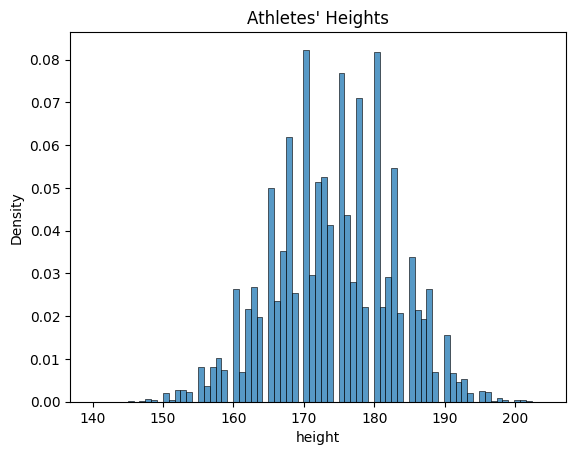

In [35]:
sns.histplot(data=olympic_running, x='height', stat='density')
plt.title('Athletes\' Heights')
plt.show()

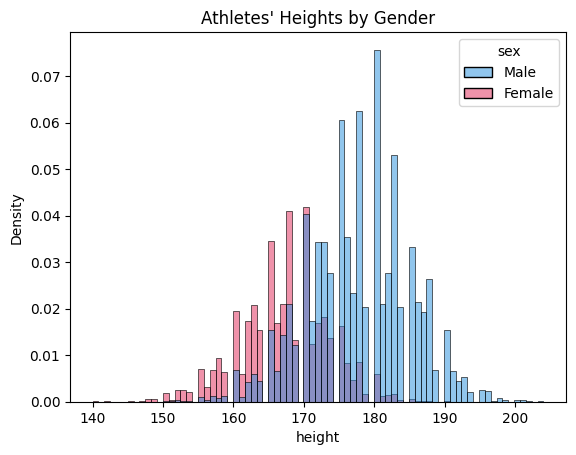

In [36]:
sns.histplot(data=olympic_running, x='height', hue='sex', palette=[cm,cf], stat='density')
plt.title('Athletes\' Heights by Gender')
plt.show()

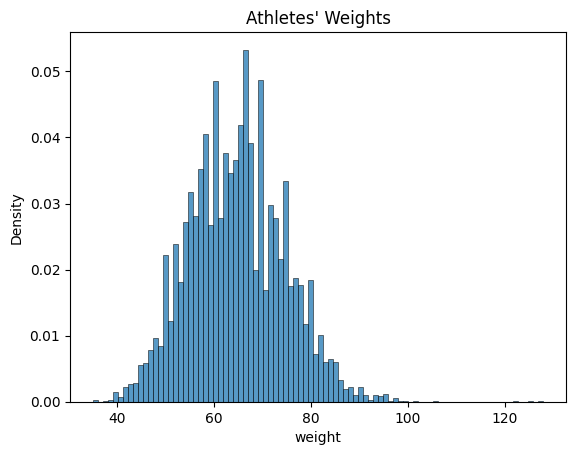

In [37]:
sns.histplot(data=olympic_running, x='weight', stat='density')
plt.title('Athletes\' Weights')
plt.show()

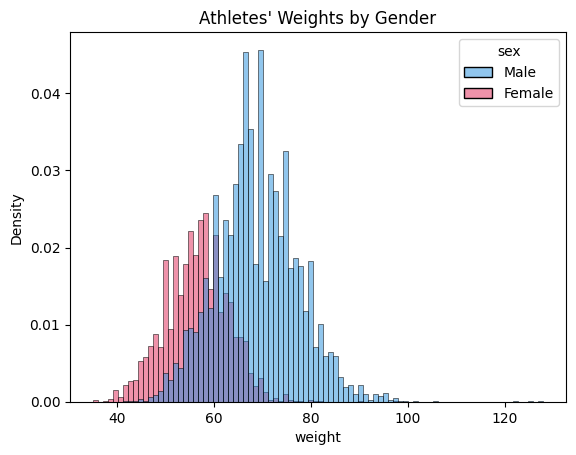

In [38]:
sns.histplot(data=olympic_running, x='weight', hue='sex', palette=[cm,cf], stat='density')
plt.title('Athletes\' Weights by Gender')
plt.show()

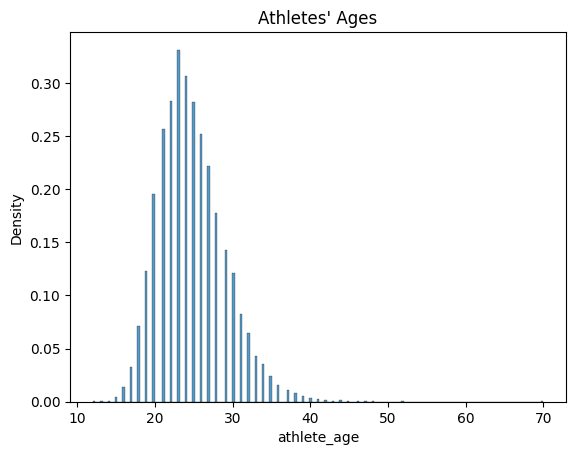

In [39]:
sns.histplot(data=olympic_running, x='athlete_age', stat='density')
plt.title('Athletes\' Ages')
plt.show()

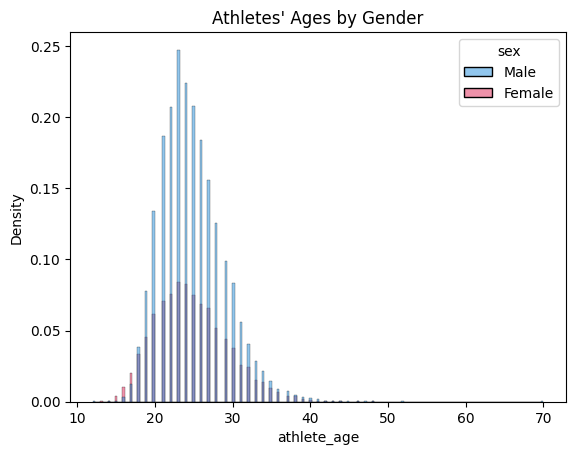

In [40]:
sns.histplot(data=olympic_running, x='athlete_age', hue='sex', palette=[cm,cf], stat='density')
plt.title('Athletes\' Ages by Gender')
plt.show()

In [41]:
olympic_running.athlete_age.describe()

count    30281.000000
mean        24.812556
std          4.243404
min         12.000000
25%         22.000000
50%         24.000000
75%         27.000000
max         70.000000
Name: athlete_age, dtype: float64

In [42]:
olympic_running[olympic_running['athlete_age'] > 50]

,edition_id,year,season,start_date,isTeamSport,event_category,event,sex,athlete_id,athlete,...,weight,born,country,country_noc,result_id,pos,medal,num_competitors,num_countries,athlete_age
98763,11,1936,Summer,1936-08-09,False,Long Distance,Marathon,Male,66287,Percy Wyer,...,45.0,1884-01-23,Canada,CAN,58231,30,NaN,56,27,52.0
292917,3,1904,Summer,1904-08-12,False,Hurdle,110/100 m Hurdles,Male,892451,Tom Moore,...,NaN,1834-01-01,United States,USA,926209,2,NaN,2,1,70.0


Note the outlier of the 70 year old male athlete. Upon closer inspection, this age belongs to Tom Moore, a hurdler from 1904. However, looking over the [many famous Tom Moores](https://en.wikipedia.org/wiki/Thomas_Moore_(disambiguation)), there is only one that has [made a name in Track and Field](https://en.wikipedia.org/wiki/Tom_Moore_(track)). The birth date of this particular Tom Moore is in 1914. Furthermore, [while there have been Olympic athletes in their 70s, the oldest record olympic track and field athlete is the 52 year old Percy Wyer](https://www.topendsports.com/events/summer/oldest-per-sport.htm). This 70 year old outlier will be removed from the dataframe before further inspeciton. 

In [43]:
olympic_running.drop(index=292917, axis=0, inplace=True)

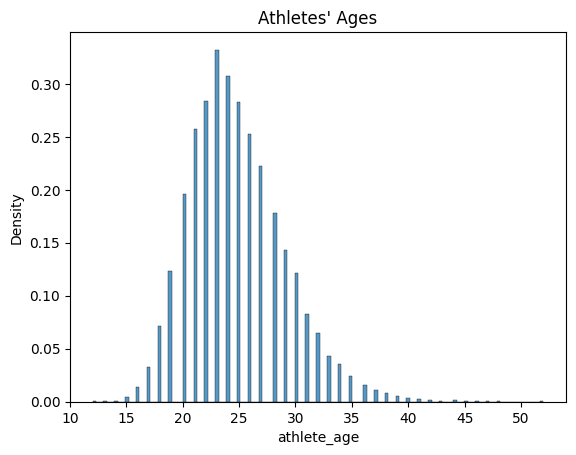

In [44]:
sns.histplot(data=olympic_running, x='athlete_age', stat='density')
plt.title('Athletes\' Ages')

plt.show()

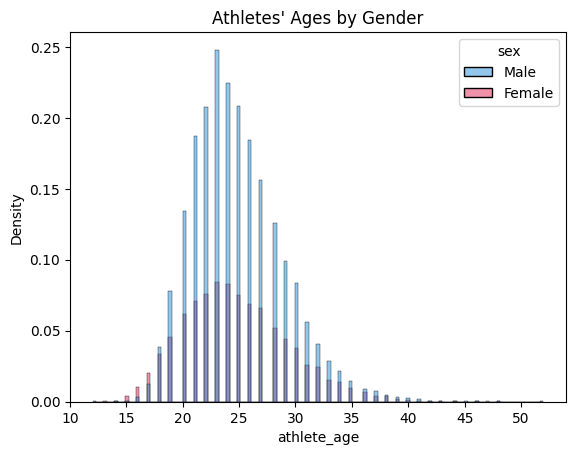

In [45]:
sns.histplot(data=olympic_running, x='athlete_age', hue='sex', palette=[cm,cf], stat='density')
plt.title('Athletes\' Ages by Gender')
plt.show()

### The Olympic Games
+ How has the participation in the events changed over time?
+ How has the representation in the events changed over time?

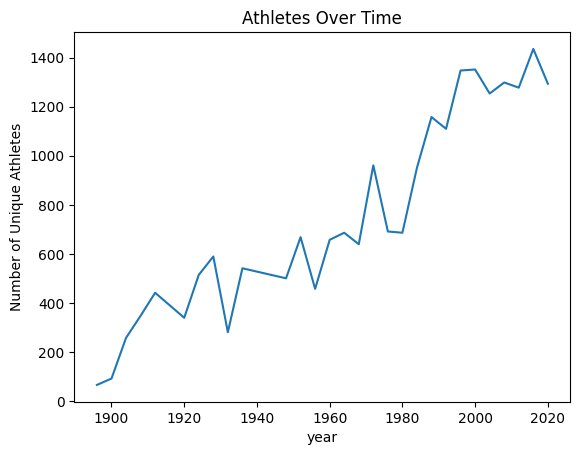

   year  athlete_id
0  1896          65
    year  athlete_id
27  2016        1436


In [66]:
athlete_totals = olympic_running.groupby('year').athlete_id.nunique().reset_index()
sns.lineplot(data=athlete_totals, x='year', y='athlete_id')
plt.title('Athletes Over Time')
plt.ylabel('Number of Unique Athletes')
plt.show()

print(athlete_totals[athlete_totals.athlete_id == athlete_totals.athlete_id.min()])
print(athlete_totals[athlete_totals.athlete_id == athlete_totals.athlete_id.max()])

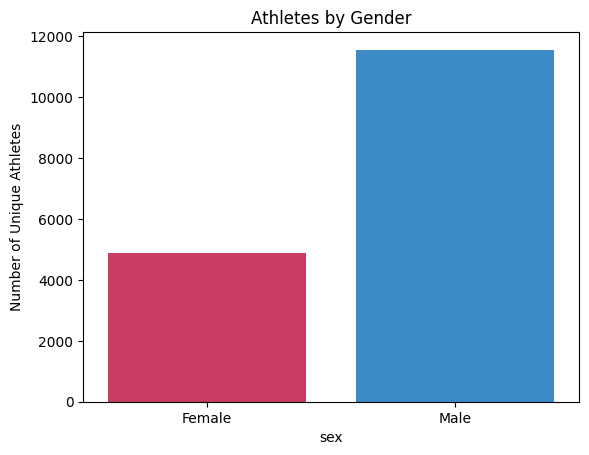

In [46]:
m_f_totals = olympic_running.groupby(['sex']).athlete_id.nunique().reset_index()[['sex', 'athlete_id']]
sns.barplot(data=m_f_totals, x='sex', y='athlete_id', palette=[cf,cm])
plt.title('Athletes by Gender')
plt.ylabel('Number of Unique Athletes')
plt.show()

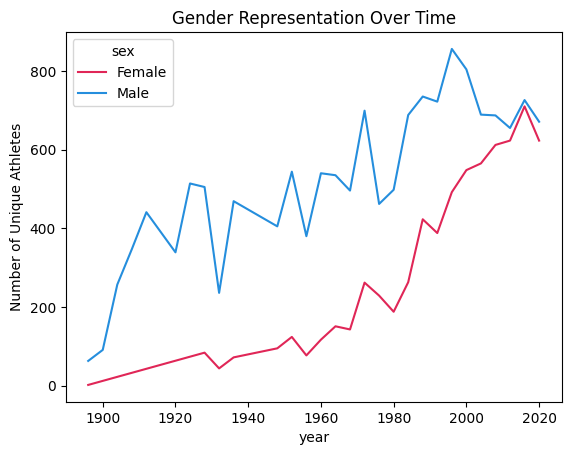

In [47]:
m_f_by_year = olympic_running.groupby(['sex', 'year']).athlete_id.nunique().reset_index()[['year','sex', 'athlete_id']]
sns.lineplot(data=m_f_by_year, x='year', y='athlete_id', hue='sex', palette=[cf, cm])
plt.title('Gender Representation Over Time')
plt.ylabel('Number of Unique Athletes')
plt.show()

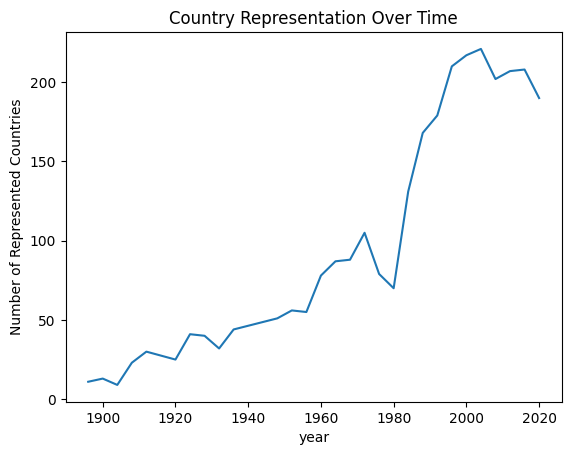

   year  country
2  1904        9
    year  country
24  2004      221


In [67]:
countries_by_year = olympic_running.groupby(['year']).country.nunique().reset_index()

sns.lineplot(data=countries_by_year, x='year', y='country')
plt.title('Country Representation Over Time')
plt.ylabel('Number of Represented Countries')
plt.show()

print(countries_by_year[countries_by_year.country == countries_by_year.country.min()])
print(countries_by_year[countries_by_year.country == countries_by_year.country.max()])

### The Athletes
+ How have athletes' body compositions changed over time?
+ How are athlete body compositions distributed across the different events?

The following section will calculate the BMI for each athlete based on their height and weight.

$$
B.M.I. = \frac{Weight}{Height^2} = \frac{kg}{m^2}
$$

NOTE:
"The BMI is a convenient rule of thumb used to broadly categorize a person as based on tissue mass (muscle, fat, and bone) and height. Major adult BMI classifications are underweight (under 18.5 kg/m2), normal weight (18.5 to 24.9), overweight (25 to 29.9), and obese (30 or more). When used to predict an individual's health, rather than as a statistical measurement for groups, the BMI has limitations that can make it less useful than some of the alternatives, especially when applied to individuals with abdominal obesity, short stature, or high muscle mass." [(source)](https://en.wikipedia.org/wiki/Body_mass_index)

In [49]:
olympic_running['athlete_bmi'] = olympic_running['weight']/((0.01*olympic_running['height'])**2)

In [50]:
measurements = olympic_running[['year', 'sex', 'weight', 'height', 'athlete_bmi', 'athlete_age']]
avg_measurements_over_time = measurements.groupby(['year', 'sex']).mean().reset_index()

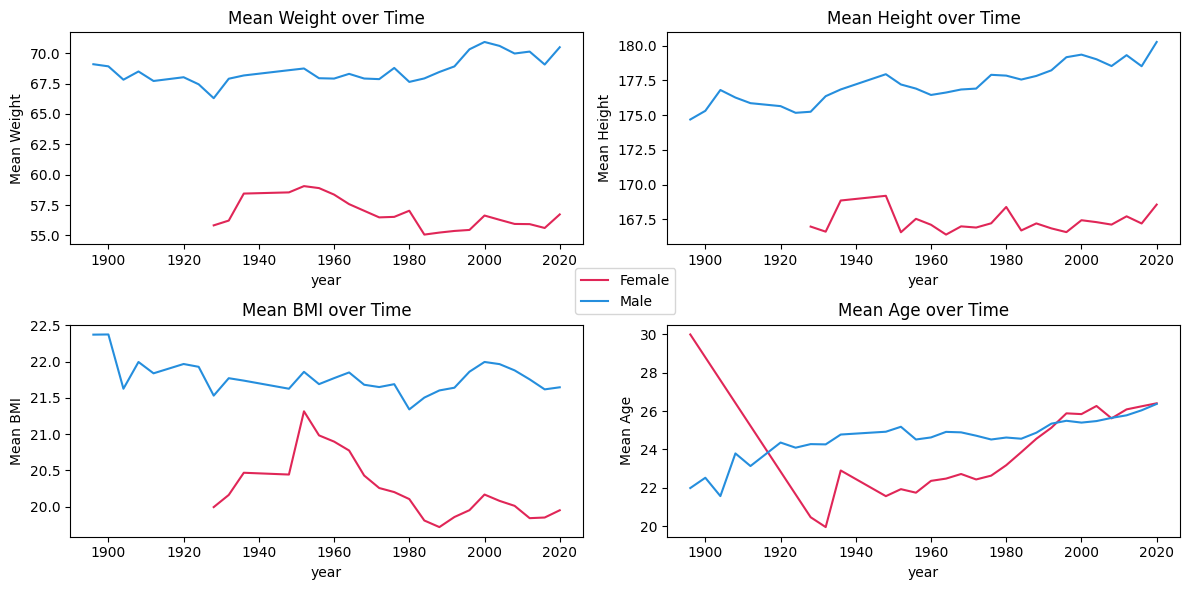

In [51]:
plt.figure(figsize=(12,6))

plt.subplot(2,2,1)
sns.lineplot(data=avg_measurements_over_time, x='year', y='weight', hue='sex', palette=[cf, cm])
plt.title('Mean Weight over Time')
plt.ylabel('Mean Weight')
leg = plt.legend()
leg.remove()

plt.subplot(2,2,2)
sns.lineplot(data=avg_measurements_over_time, x='year', y='height', hue='sex', palette=[cf, cm])
plt.title('Mean Height over Time')
plt.ylabel('Mean Height')
leg = plt.legend()
leg.remove()

plt.subplot(2,2,3)
sns.lineplot(data=avg_measurements_over_time, x='year', y='athlete_bmi', hue='sex', palette=[cf, cm])
plt.title('Mean BMI over Time')
plt.ylabel('Mean BMI')
leg = plt.legend()
leg.remove()

plt.subplot(2,2,4)
sns.lineplot(data=avg_measurements_over_time, x='year', y='athlete_age', hue='sex', palette=[cf, cm])
plt.title('Mean Age over Time')
plt.ylabel('Mean Age')

plt.tight_layout()
plt.legend(bbox_to_anchor=(0.03, 1.3))
plt.show()

In [52]:
# Funciton expects one dataframes with all athletes.
# DF requires columns 'sex','weight', 'height', 'athlete_bmi', 'athlete_age'
# x_col is an additional categorical column in the dataframe to create the x-axis for the bar plots.
def gender_split_bars(df_stats, x_col):
    plt.figure(figsize=(12,10))

    llim = df_stats.weight.min()*0.9
    hlim = df_stats.weight.max()*1.1
    plt.subplot(2,2,1)
    sns.barplot(data=df_stats, x=x_col, y='weight', hue='sex', palette=[cf, cm])
    plt.xticks(rotation=90)
    plt.ylim([llim,hlim])
    plt.ylabel("Average Weight")
    plt.title("Weight by Event")
    leg = plt.legend()
    leg.remove()

    llim = df_stats.height.min()*0.9
    hlim = df_stats.height.max()*1.1
    plt.subplot(2,2,2)
    sns.barplot(data=df_stats, x=x_col, y='height', hue='sex', palette=[cf, cm])
    plt.xticks(rotation=90)
    plt.ylim([llim,hlim])
    plt.ylabel("Average Height")
    plt.title("Height by Event")
    leg = plt.legend()
    leg.remove()

    llim = df_stats.athlete_bmi.min()*0.9
    hlim = df_stats.athlete_bmi.max()*1.1
    plt.subplot(2,2,3)
    sns.barplot(data=df_stats, x=x_col, y='athlete_bmi', hue='sex', palette=[cf, cm])
    plt.xticks(rotation=90)
    plt.ylim([llim,hlim])
    plt.ylabel("Average BMI")
    plt.title("BMI by Event")
    leg = plt.legend()
    leg.remove()

    llim = df_stats.athlete_age.min()*0.9
    hlim = df_stats.athlete_age.max()*1.1
    plt.subplot(2,2,4)
    sns.barplot(data=df_stats, x=x_col, y='athlete_age', hue='sex', palette=[cf, cm])
    plt.xticks(rotation=90)
    plt.ylim([llim,hlim])
    plt.ylabel("Average Age")
    plt.title("Age by Event")
    
    plt.tight_layout()
    plt.legend(bbox_to_anchor=(0.05, 1.4))
    plt.show()

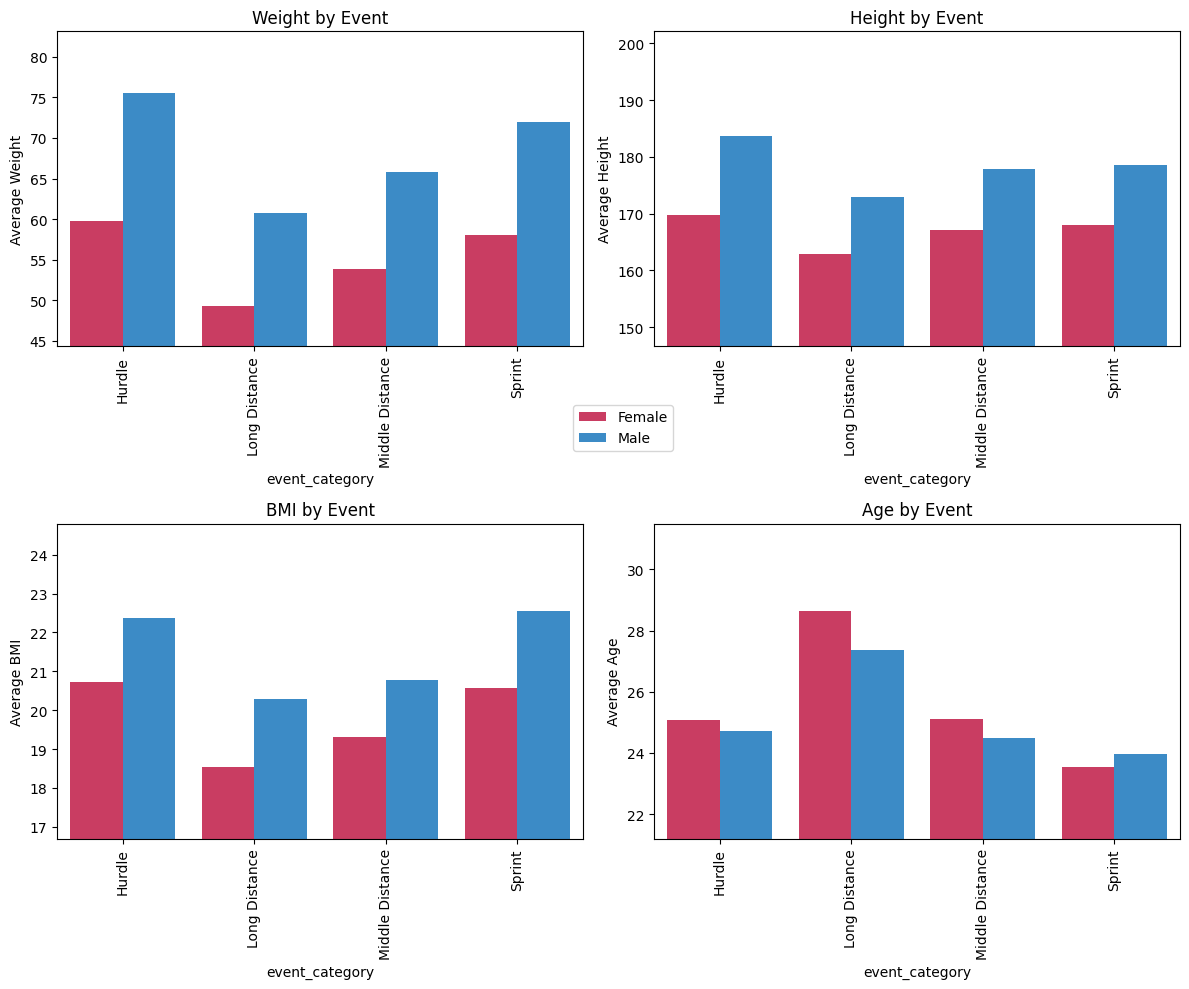

In [53]:
avgs_by_event_cat = olympic_running[['sex','event_category','height','weight','athlete_age', 'athlete_bmi']]\
        .groupby(['event_category','sex'])\
        .mean()\
        .reset_index()
gender_split_bars(avgs_by_event_cat, 'event_category')

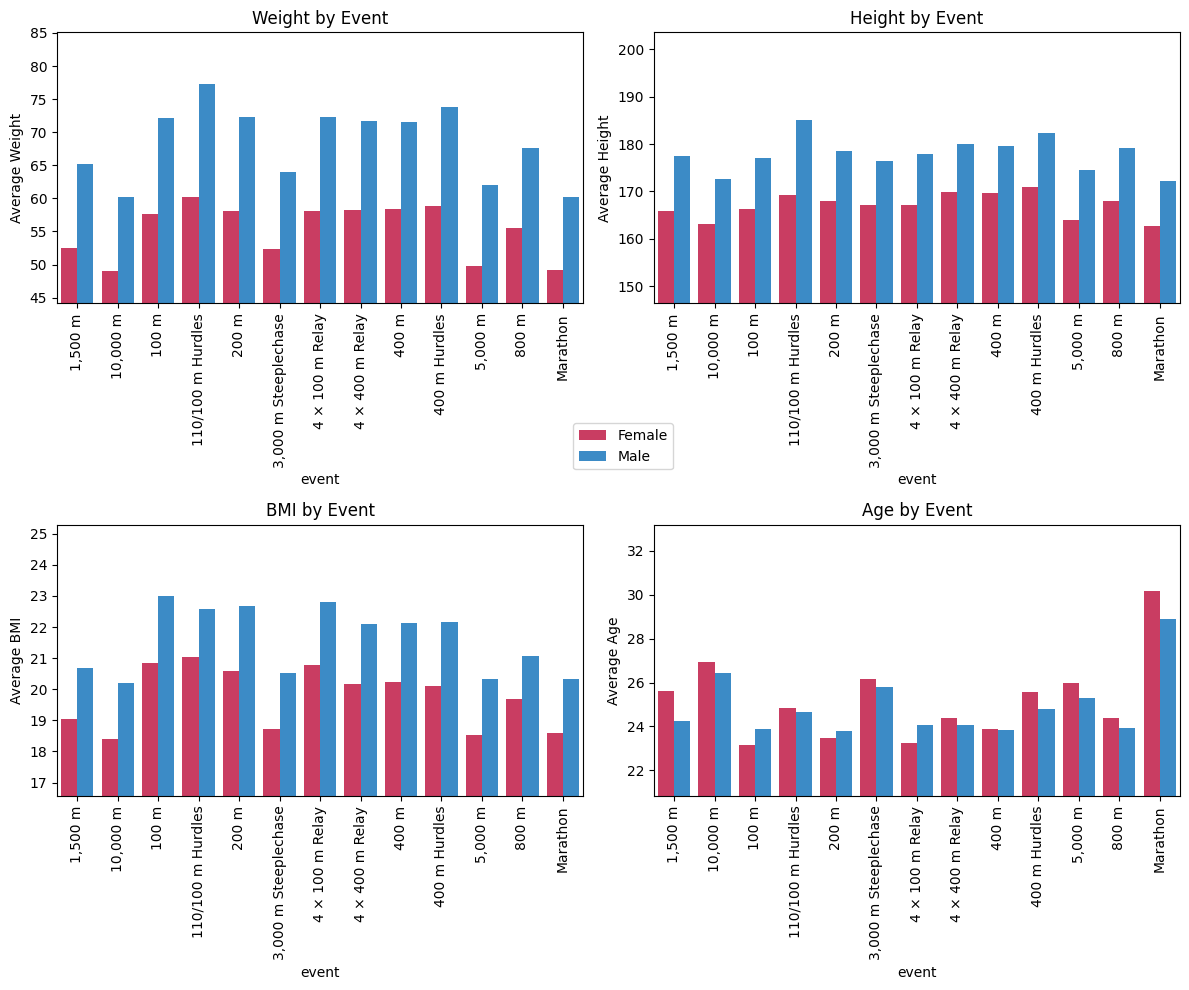

In [54]:
avgs_by_event = olympic_running[['sex','event','height','weight','athlete_age', 'athlete_bmi']]\
        .groupby(['event','sex'])\
        .mean()\
        .reset_index()

gender_split_bars(avgs_by_event, 'event')

Now, let's compare medalists to non-medalists. All following analyses will be separated by gender, since there is a sizeable difference between male and female athletes in heights, weights, and BMIs.

+ What does a medalist look like in each event? How does this compare to a non-medalist?
    + Height
    + Weight
    + Age 

In [55]:
medalists = olympic_running[~pd.isnull(olympic_running['medal'])]
medalists = olympic_running[['medal', 'year', 'sex','weight', 'height', 'athlete_bmi', 'athlete_age']]
avg_medalists = medalists.groupby(['medal', 'year', 'sex']).mean().reset_index()

male_medalists = avg_medalists[avg_medalists.sex == 'Male']
female_medalists = avg_medalists[avg_medalists.sex == 'Female']

nonmedalists = olympic_running[pd.isnull(olympic_running['medal'])]
nonmedalists = nonmedalists[['year', 'sex','weight', 'height', 'athlete_bmi', 'athlete_age']]
avg_nonmedalists = nonmedalists.groupby(['year', 'sex']).mean().reset_index()

male_nonmedalists = avg_nonmedalists[avg_nonmedalists.sex == 'Male']
female_nonmedalists = avg_nonmedalists[avg_nonmedalists.sex == 'Female']

In [56]:
# Funciton expects two dataframes that are homogenous for athlete gender.
# Each DF requires columns 'medal', 'year', 'sex','weight', 'height', 'athlete_bmi', 'athlete_age'
# First DF is only medailsts.
# Second DF sohuld be only non-medalists.
def plot_medalist_stats(df_medals, df_nonmedals):
    cb = '#cd7f32'
    cs = '#c0c0c0'
    cg = '#ffd700'
    nm = '#000000'

    gender_for_title = df_medals.iloc[1].sex
    
    plt.figure(figsize=(12,6))
    plt.suptitle(f"{gender_for_title} Medalists vs Non-medalists\nMeasurements Over Time")
    
    plt.subplot(2,2,1)
    sns.lineplot(data=df_medals, x='year', y='weight', hue='medal', palette=[cg, cs, cb])
    sns.lineplot(data=df_nonmedals, x='year', y='weight', color=nm, linestyle='--', label='No Medal')
    plt.title('Mean Weight over Time')
    plt.ylabel('Mean Weight')
    leg = plt.legend()
    leg.remove()
    
    plt.subplot(2,2,2)
    sns.lineplot(data=df_medals, x='year', y='height', hue='medal', palette=[cg, cs, cb])
    sns.lineplot(data=df_nonmedals, x='year', y='height', color=nm, linestyle='--', label='No Medal')
    plt.title('Mean Height over Time')
    plt.ylabel('Mean Height')
    leg = plt.legend()
    leg.remove()
    
    plt.subplot(2,2,3)
    sns.lineplot(data=df_medals, x='year', y='athlete_bmi', hue='medal', palette=[cg, cs, cb])
    sns.lineplot(data=df_nonmedals, x='year', y='athlete_bmi', color=nm, linestyle='--', label='No Medal')
    plt.title('Mean BMI over Time')
    plt.ylabel('Mean BMI')
    leg = plt.legend()
    leg.remove()
    
    plt.subplot(2,2,4)
    sns.lineplot(data=df_medals, x='year', y='athlete_age', hue='medal', palette=[cg, cs, cb])
    sns.lineplot(data=df_nonmedals, x='year', y='athlete_age', color=nm, linestyle='--', label='No Medal')
    plt.title('Mean Age over Time')
    plt.ylabel('Mean Age')
    
    plt.tight_layout()
    plt.legend(bbox_to_anchor=(1, 1))
    plt.show()
    
    

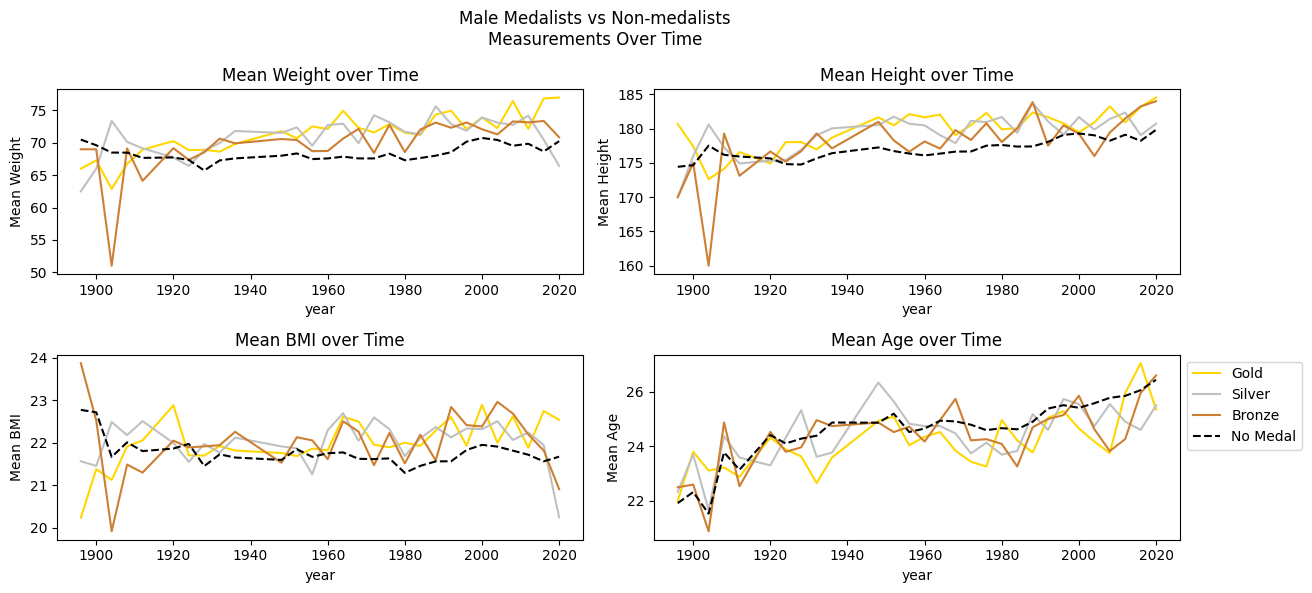

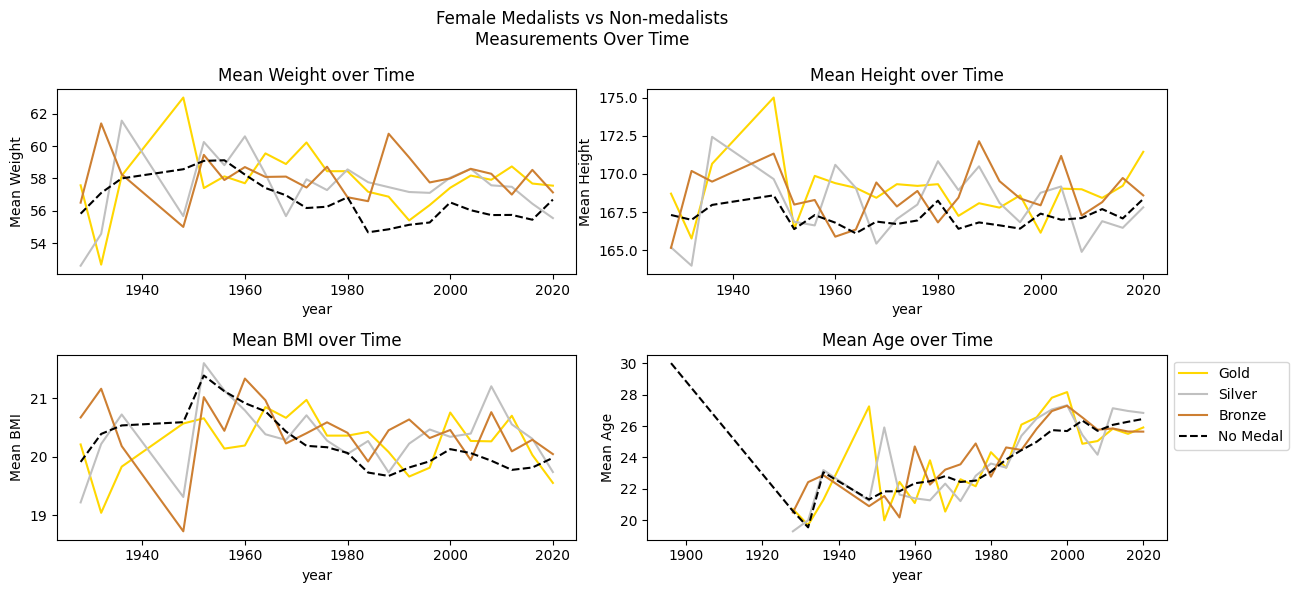

In [57]:
plot_medalist_stats(male_medalists, male_nonmedalists)
plot_medalist_stats(female_medalists, female_nonmedalists)

In [58]:
# Funciton expects two dataframes, that are homogenous for athlete gender.
# x_col is a common column in each data frame intended for use as the x-akis of the bar plots.
# Each DF requires additional columns 'sex','weight', 'height', 'athlete_bmi', 'athlete_age'
# First DF is only medailsts, contanining the column 'medal'.
# Second DF sohuld be only non-medalists.
def medal_split_bars(df_medals, df_nonmedals, x_col):

    cb = '#cd7f32'
    cs = '#c0c0c0'
    cg = '#ffd700'
    nm = '#000000'

    a=0.55
    lw=1.5

    gender_for_title = df_medals.iloc[1].sex
    
    plt.figure(figsize=(12,10))
    plt.suptitle(f"{gender_for_title} Medalists vs Non-medalists\nBy {x_col}")

    llim = min(df_medals.weight.min(), df_nonmedals.weight.min())*0.9
    hlim = min(df_medals.weight.max(), df_nonmedals.weight.max())*1.1
    plt.subplot(2,2,1)
    sns.barplot(data=df_medals, x=x_col, y='weight', hue='medal', palette=[cg, cs, cb])
    sns.barplot(data=df_nonmedals, x=x_col, y='weight', color=nm, label='No Medal', alpha=a, edgecolor=nm, linewidth=lw, linestyle='--')
    plt.xticks(rotation=90)
    plt.ylim([llim,hlim])
    plt.ylabel("Average Weight")
    plt.title("Weight by Event")
    leg = plt.legend()
    leg.remove()

    llim = min(df_medals.height.min(), df_nonmedals.height.min())*0.9
    hlim = min(df_medals.height.max(), df_nonmedals.height.max())*1.1
    plt.subplot(2,2,2)
    sns.barplot(data=df_medals, x=x_col, y='height', hue='medal', palette=[cg, cs, cb])
    sns.barplot(data=df_nonmedals, x=x_col, y='height', color=nm, label='No Medal', alpha=a, edgecolor=nm, linewidth=lw, linestyle='--')
    plt.xticks(rotation=90)
    plt.ylim([llim,hlim])
    plt.ylabel("Average Height")
    plt.title("Height by Event")
    leg = plt.legend()
    leg.remove()

    llim = min(df_medals.athlete_bmi.min(), df_nonmedals.athlete_bmi.min())*0.9
    hlim = min(df_medals.athlete_bmi.max(), df_nonmedals.athlete_bmi.max())*1.1
    plt.subplot(2,2,3)
    sns.barplot(data=df_medals, x=x_col, y='athlete_bmi', hue='medal', palette=[cg, cs, cb])
    sns.barplot(data=df_nonmedals, x=x_col, y='athlete_bmi', color=nm, label='No Medal', alpha=a, edgecolor=nm, linewidth=lw, linestyle='--')
    plt.xticks(rotation=90)
    plt.ylim([llim,hlim])
    plt.ylabel("Average BMI")
    plt.title("BMI by Event")
    leg = plt.legend()
    leg.remove()

    llim = min(df_medals.athlete_age.min(), df_nonmedals.athlete_age.min())*0.9
    hlim = min(df_medals.athlete_age.max(), df_nonmedals.athlete_age.max())*1.1
    plt.subplot(2,2,4)
    sns.barplot(data=df_medals, x=x_col, y='athlete_age', hue='medal', palette=[cg, cs, cb])
    sns.barplot(data=df_nonmedals, x=x_col, y='athlete_age', color=nm, label='No Medal', alpha=a, edgecolor=nm, linewidth=lw, linestyle='--')
    plt.xticks(rotation=90)
    plt.ylim([llim,hlim])
    plt.ylabel("Average Age")
    plt.title("Age by Event")
    
    plt.tight_layout()
    plt.legend(bbox_to_anchor=(1, 1))
    plt.show()

In [59]:
medalists = olympic_running[~pd.isnull(olympic_running['medal'])]
medalists = olympic_running[['medal', 'event_category', 'sex','weight', 'height', 'athlete_bmi', 'athlete_age']]
avg_medalists = medalists.groupby(['medal', 'event_category', 'sex']).mean().reset_index()

male_medalists = avg_medalists[avg_medalists.sex == 'Male']
female_medalists = avg_medalists[avg_medalists.sex == 'Female']

nonmedalists = olympic_running[pd.isnull(olympic_running['medal'])]
nonmedalists = nonmedalists[['event_category', 'sex','weight', 'height', 'athlete_bmi', 'athlete_age']]
avg_nonmedalists = nonmedalists.groupby(['event_category', 'sex']).mean().reset_index()

male_nonmedalists = avg_nonmedalists[avg_nonmedalists.sex == 'Male']
female_nonmedalists = avg_nonmedalists[avg_nonmedalists.sex == 'Female']

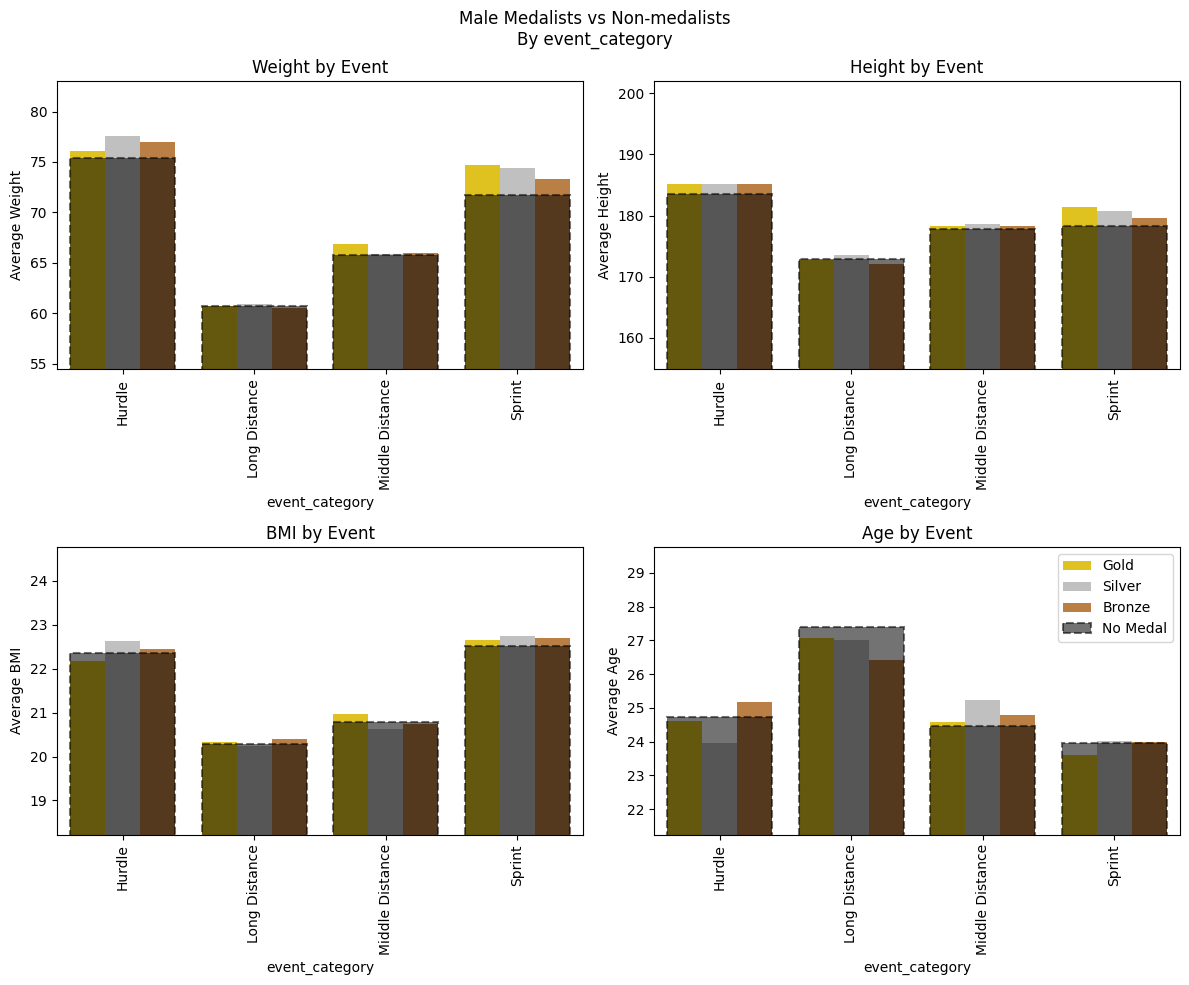

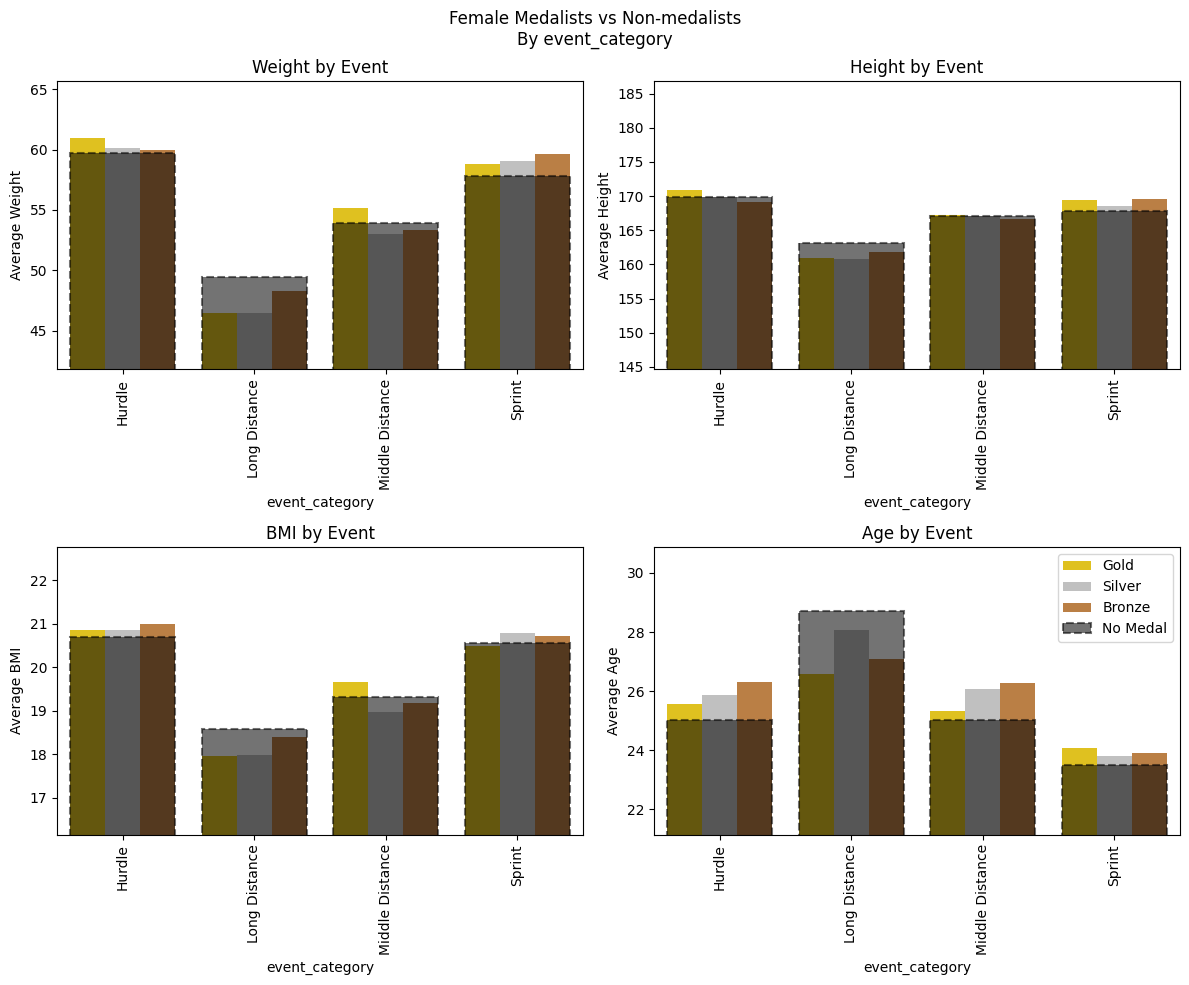

In [60]:
medal_split_bars(male_medalists, male_nonmedalists, 'event_category')
medal_split_bars(female_medalists, female_nonmedalists, 'event_category')

In [61]:
medalists = olympic_running[~pd.isnull(olympic_running['medal'])]
medalists = olympic_running[['medal', 'event', 'sex','weight', 'height', 'athlete_bmi', 'athlete_age']]
avg_medalists = medalists.groupby(['medal', 'event', 'sex']).mean().reset_index()

male_medalists = avg_medalists[avg_medalists.sex == 'Male']
female_medalists = avg_medalists[avg_medalists.sex == 'Female']

nonmedalists = olympic_running[pd.isnull(olympic_running['medal'])]
nonmedalists = nonmedalists[['event', 'sex','weight', 'height', 'athlete_bmi', 'athlete_age']]
avg_nonmedalists = nonmedalists.groupby(['event', 'sex']).mean().reset_index()

male_nonmedalists = avg_nonmedalists[avg_nonmedalists.sex == 'Male']
female_nonmedalists = avg_nonmedalists[avg_nonmedalists.sex == 'Female']

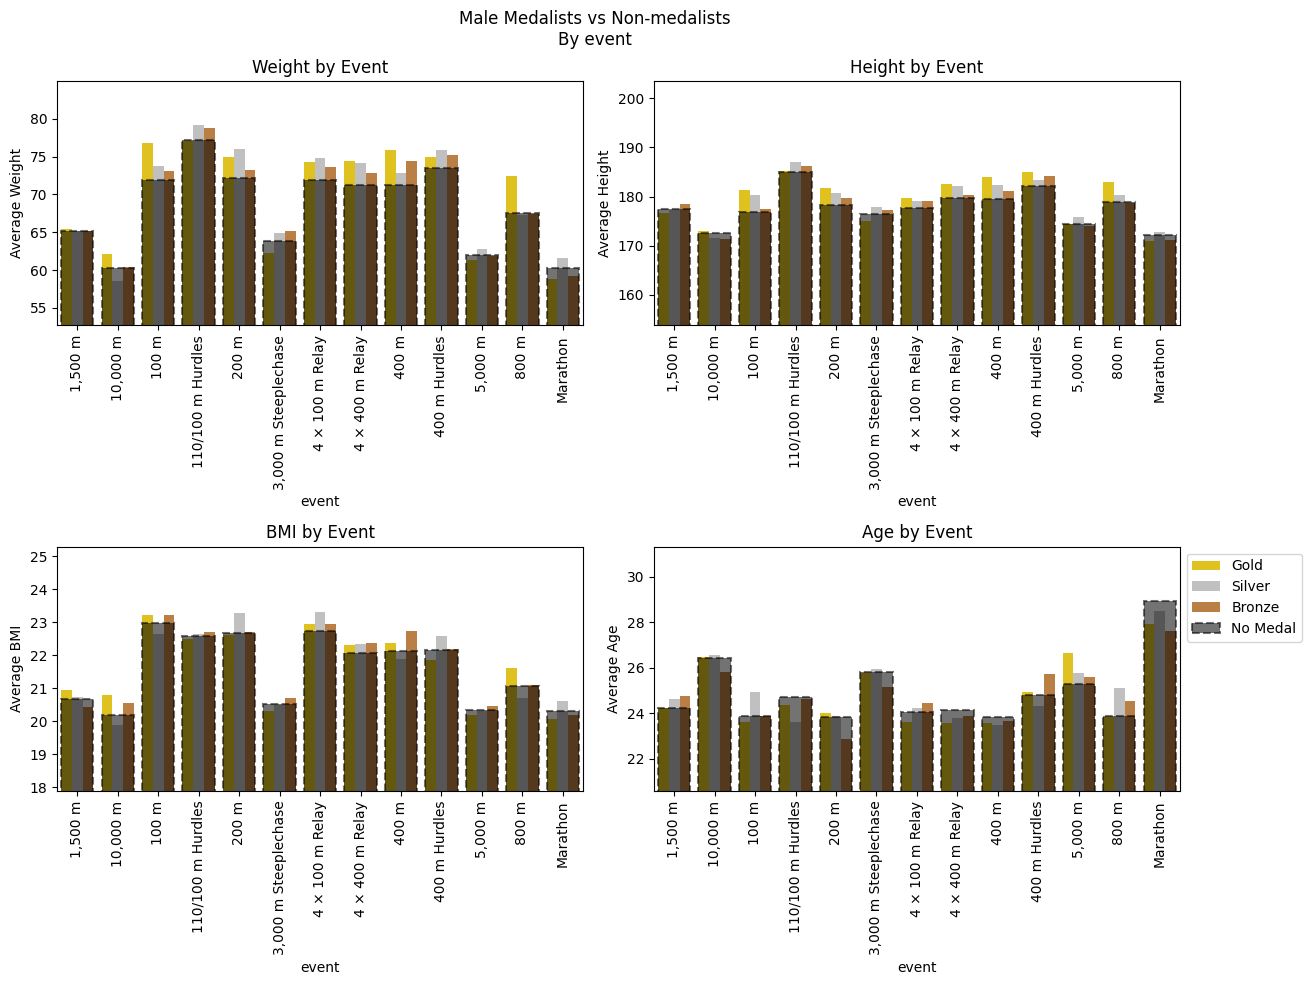

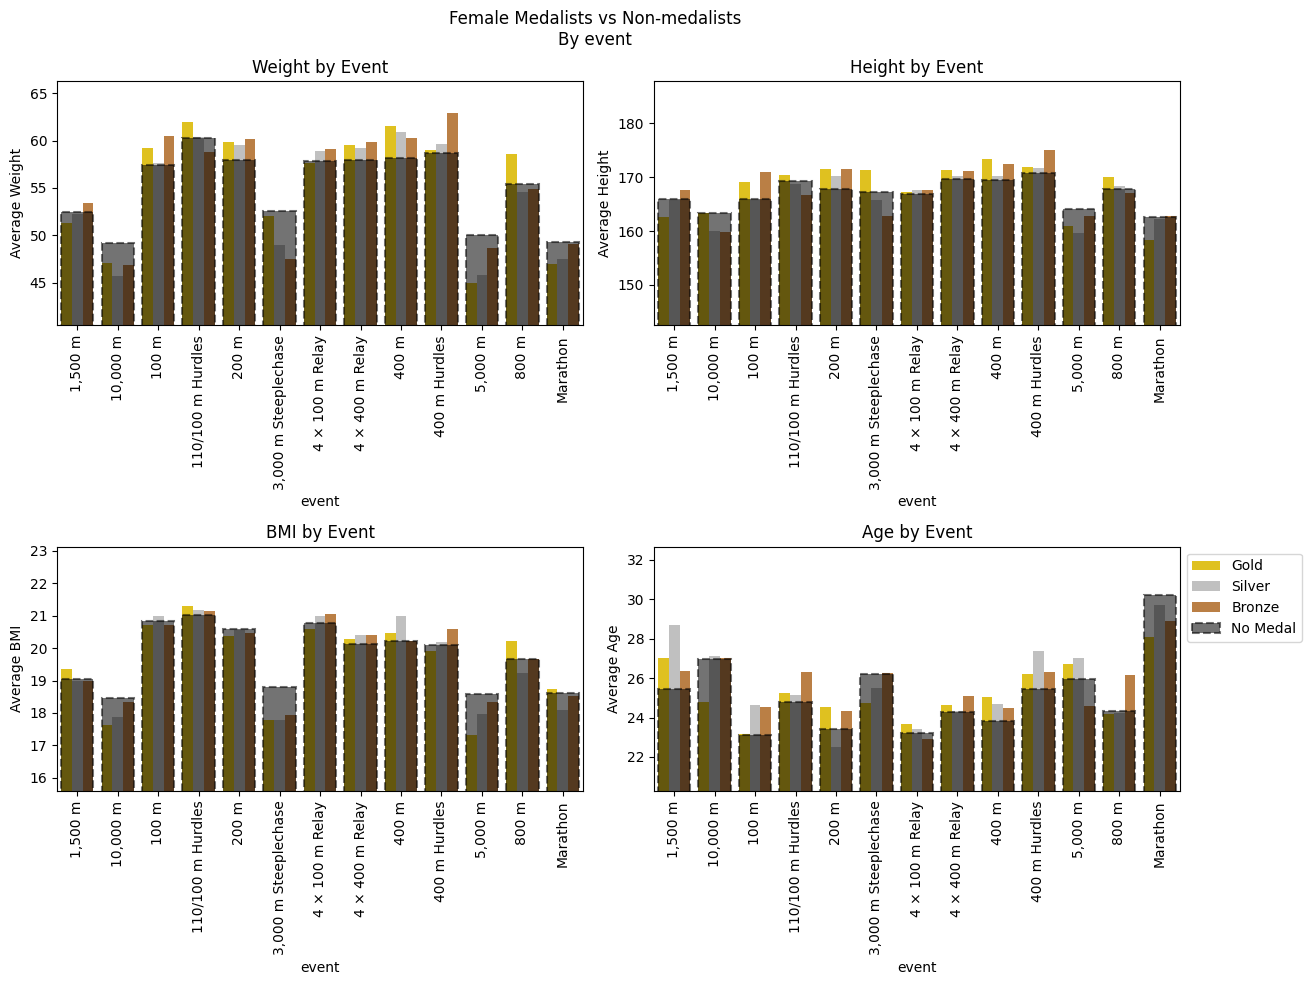

In [62]:
medal_split_bars(male_medalists, male_nonmedalists, 'event')
medal_split_bars(female_medalists, female_nonmedalists, 'event')

+ What is the correlation between height and weight?
    + For sprinting events?
    + For mid-distance events?
    + For long-distance events? 

In [63]:
olympic_males = olympic_running[olympic_running.sex == 'Male']
olympic_females = olympic_running[olympic_running.sex == 'Female']

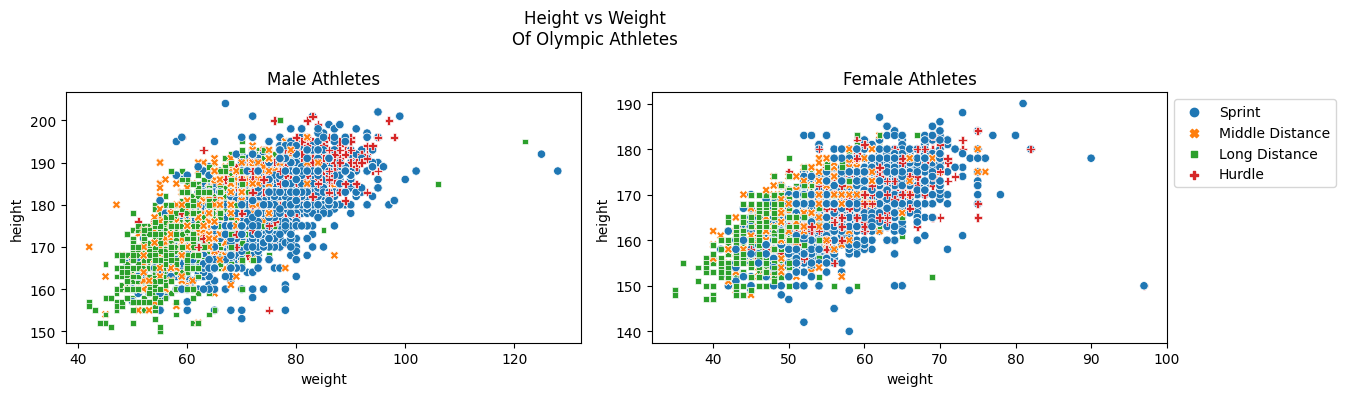

In [64]:
plt.figure(figsize=(12,4))
plt.suptitle("Height vs Weight\nOf Olympic Athletes")

plt.subplot(1,2,1)
plt.title("Male Athletes")
sns.scatterplot(data=olympic_males, x='weight', y='height', 
                hue='event_category', hue_order=['Sprint', 'Middle Distance', 'Long Distance', 'Hurdle'],
                style='event_category', style_order=['Sprint', 'Middle Distance', 'Long Distance', 'Hurdle'])
leg = plt.legend()
leg.remove()

plt.subplot(1,2,2)
plt.title("Female Athletes")
sns.scatterplot(data=olympic_females, x='weight', y='height',
                hue='event_category', hue_order=['Sprint', 'Middle Distance', 'Long Distance', 'Hurdle'],
                style='event_category', style_order=['Sprint', 'Middle Distance', 'Long Distance', 'Hurdle'])

plt.tight_layout()
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

## Conclusions

### The Olympic Games
#### How has the participation in the events changed over time?
The number of athletes has increased rapidly since the 1896 games. The smallest games was in 1896 and had only 65 athletes. The largest games was in 2016 with over 1400 athletes. There are only 11 instances where there were fewer athletes than were at the previous summer games.
#### How has the representation in the events changed over time?
Overall, there is significantly less female representation in the olympic games than there is male representation. Even though females were first permitted to compete in the 1900 Summer Olympic Games there have been **large** discrepancies between the number of male athelets and the number of female athletes up until the mid-2000s. The greatest of these discrepancies took place between the 1910s and the 1960s. Despite the numbers being much closer now than at any point in history ,there are still fewer female athelets than male athletes.

As time has passed, the number of countries being represented at the olympic games has greatly increased from a low of only 9 countries in 1904 up to a high of 221 countries in 2004. The number of represented countries has incerased at a much greater rate since the 1980s than it did prior to the 1980s. 

### The Athletes
#### How have athletes' body compositions changed over time?
Regarding weight, after an initial decrease up until the 1930s, the average olympic male has gotten heavier. After an initial increase up until the 1950s, the average olympic female has gotten lighter.

Regarding height, there has been a steady increase in the height of the average olympic male. The height of the average olympic female has been relatively steady since the 1950s, though there has been a very slight upward trend since the 1990s.

Regarding BMI, there was a steady decline in the BMI of the average male olympian up until the 1980s, after which there has been an upward trend. Despite the recent increases, BMI has trended downward since the 1900s. For female athlete's there was a rapid incerase in BMI from the 1920s until the 1950s. It has since trended downwards, reaching its low in the late 1980s.

Regarding age, both male and female athletes have steadily gotten older over time (with the exception of a few *early* female competitors in the 1900s)
#### How are athlete body compositions distributed across the different events?
On average, the heaviest and tallest athletes are hurdlers. This is true for both males and females, though the differences between sprinters and hurdlers is less pronounced for females. On average, the lightset and shortest athletes are long-distance runners. The difference in weight is most pronounced with female athletes. For both male and female athletes, while there is little-to-no difference in height between the average sprinter and the average mid-distance runner, the weights of the sprinters are greater.

#### What does a medalist look like in each event? How does this compare to a non-medalist?
For male athletes, medalists are generally taller and heavier than their non-medalist counterparts. This is especially prominent in sprinters and hurdlers. For distance runners, there is nearly no difference between medalists and non-medalists. The BMIs of medalists and non-medalists is very close across every discipline. Regarding age, medalists are typically slightly younger than non-medalists, except for in the middle-distance events where they are slightly older. The differences between medalists and non-medalists became more prevalent after the 1920s.

For female athletes, medalists have slightly higher weights than their non-medalist counterparts, and their heights are *very* similar. The exception to this observation are the distance runners, where the medalists are 2-3 cm shorter and 3-4 kg lighter. There is greater separation in BMI between female medalists and non-medalists than was shown in males, but the values are still very close together. Again, distance runners have lower BMIs than the athletes of other disciplines. Regarding age, unlike the males, medalists are typically older than non-medalists except for in the long-distance events. The differences between medalists and non-medalists became more prevalent after the 1980s.  
     
#### What is the correlation between height and weight?
For both male and female athletes, height and weight have a clear positive corellation. Heavier athletes are generally taller, and lighter athletes are generally shorter. Long distance runners tend to be the lightest and shortest, while sprinters tend to be heaviest and tallest athletes. The middle-distance athletes are, un-suprisingly grouped in the middle of the long distance athletes in terms of height and weight, but they are scattered amongst both the distance runners and the sprinters. The greatest amount of variation between the genders is displayed by the hurdlers. Male hurdlers are tightly grouped together at the upper end of height and weight with the sprinters, while female hurdlers are more spread out through the full range of sprinters. 

## Further Questions
Given that women have been able to compete in the Olypic Games for all-but-one-year of the provided data set, why is female representation so much lower than male representation? 
+ Were there barriers to entry from the IOC?
+ Was there a lack of interest?
+ Was it based on womens' rights in many of represented countries?
+ Were the other factors contributing to the under-representation of women? 